In [1]:
from tqdm.notebook import tqdm
import numpy as np
from numpy import moveaxis
import torch
from torch.utils.data.sampler import Sampler
from torch.utils.data import TensorDataset 
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn                                                
from torch.optim.lr_scheduler import StepLR
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
import time
import cv2


In [2]:
paths = [
    "numpy/chicken.npy",
    "numpy/pig.npy",
    "numpy/panda.npy",
    "numpy/terrain.npy"

]

In [3]:
def extract_column(arr, index):
    x_train = []
    for m in range (len(arr)):
        x_train.append(arr[m][index])
    return(np.array(x_train))

def load_numpy_arrays(paths_list):
    s = []
    for i in paths_list:
        s.append(np.array(np.load( i , allow_pickle = True)))
    arr = np.vstack(tuple(j for j in s))
    del s
    return arr

def view_samples_from_training_data(arr, skip_val):
    images = []
    for i in range (0,len(arr), skip_val):
        foo = np.moveaxis(arr[i][0], 0, 2)
        images.append(foo)
    f = plt.figure(figsize = (25,20))
    for m in range (1,len(images)):
        f.add_subplot(1,len(images), m)
        plt.imshow(images[m])
    plt.show()

def preprocess_to_tensors_for_training(np_array, batch_size, val_batch_size):

    x_train = extract_column(np_array,0)
    y_train = extract_column(np_array,1)
    x_train_tensor = torch.from_numpy(x_train).float()
    y_train_tensor = torch.from_numpy(y_train).float()
    full_dataset = TensorDataset(x_train_tensor, y_train_tensor)    ## make compatible with DataLoader 
    train_size = int(0.8 * len(full_dataset))  ## 90/10 split
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=test_dataset, batch_size=val_batch_size, shuffle = True)
    print(len(train_loader), "batches ")
    print(len(val_loader), " batches ")

    return train_loader, val_loader



def vis_loss_multi_colors(loss_arr,val_arr):
    
    ysmoothed = gaussian_filter1d(loss_arr, sigma=3)
    plt.plot( ysmoothed, "c", label = "training")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=7)
    plt.plot(ysmoothed2, "g", label = "validation")
    plt.grid(True)
    plt.ylabel("Loss", fontsize=15)
    plt.xlabel("batches", fontsize=15)
    plt.legend()
    plt.show()

(6000, 2)


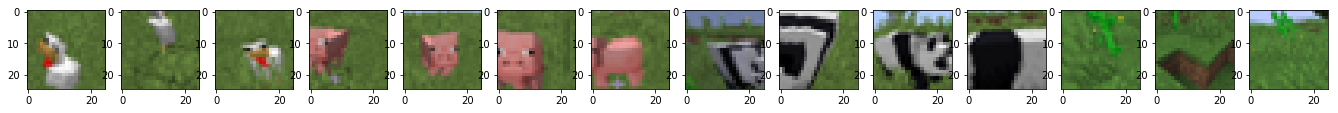

400 batches 
400  batches 


In [4]:
train_data_np_array = load_numpy_arrays(paths)
print(train_data_np_array.shape)
view_samples_from_training_data(train_data_np_array, skip_val = 400)
train_set, val_set = preprocess_to_tensors_for_training(np_array = train_data_np_array, batch_size = 12, val_batch_size=3)

In [12]:
def train_step(x, y, cellnet, optimizer):
        optimizer.zero_grad()
#         x_val = x_val.unsqueeze(0)

        pred = cellnet(x)
        y = y.long()
        loss = F.cross_entropy(pred,y)
        loss.backward()
        optimizer.step()        
        return loss.item()

def train(cellnet, epochs, train_loader, val_loader, optimizer):
    start = time.time()
    losses = []
    val_losses = []
    times = []
    timed_val_losses = []

    for m in range (epochs):
        clear_output()
        print ("epoch ", m+1, " out of ", epochs )
        
        with torch.no_grad():
            cellnet.eval()

            for x_val, y_val in val_loader:
                y_val =  y_val.long()
#                 x_val = x_val.unsqueeze(0)
                yhat =cellnet(x_val)  # pred 
                val_loss = F.cross_entropy(yhat, y_val)
                val_losses.append(val_loss.item())  ## metrics 
                
                timed_val_losses.append(val_loss.item())
                times.append(time.process_time()- start)
        cellnet.train()
        
        for x_batch, y_batch in tqdm(train_loader, desc = " Training batches : "):
                loss = train_step(x_batch, y_batch, cellnet, optimizer)
                losses.append(loss)
        scheduler.step()   ## lr decay caller 

    clear_output()
    vis_loss_multi_colors(losses, val_losses)
    print ("Time elapsed = ", time.time() - start, " seconds" )
    return losses, val_losses

def calculate_accuracy_on_validation_set(val_loader, cellnet):
    
    cellnet.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for batch in val_loader:
            x_val, y_val = batch
            pred = cellnet(x_val)  # pred()
            scores = ([i.item() for i in (torch.eq(torch.argmax(pred,dim = 1).float(), y_val))])
            for m in scores:
                total+= 1 
                if m == True:
                    correct +=1 
        acc = (correct/total)*100
        return acc

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 7, 5)
        self.pool = nn.MaxPool2d(3, 3)
        
        self.dropout = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(7, 10, 5)
        
        
        self.fc1 = nn.Linear(10, 10)
        self.fc2 = nn.Linear(10, 8)
        self.fc3 = nn.Linear(8, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
hunter = Net()
print (hunter)

optimizer = optim.Adam(hunter.parameters(), lr = 0.001) 
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)  # lr decreases by 1% aftr every epoch

Net(
  (conv1): Conv2d(3, 7, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(7, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
)


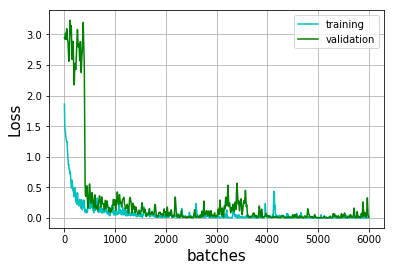

Time elapsed =  26.589595079421997  seconds


In [23]:
losses, val_losses = train(hunter, 15, train_set, val_set, optimizer)

In [24]:
calculate_accuracy_on_validation_set(val_set, hunter)

99.5

In [25]:
torch.save(hunter.state_dict(), "hunter.pt")